# ALNS

## Repair

In [20]:
class RepairOperators:
    def __init__(self, solution):
        self.solution = deepcopy(solution)
        self.instance = solution.instance
        self.insertion_log = []  # record

    #*****************************************************************************************************
    #Start of greedy insertion
    def greedy_insertion(self, removed_pairs):
        # loop the removed pairs
        for pickup, delivery in removed_pairs:
            best_cost = float('inf')
            best_route = None
            best_insert_position = None
            # loop each route to find a suitable location to insert 
            temp_solution = deepcopy(self.solution)
            for vehicle_id, route in enumerate(self.solution.routes):
                for i in range(1, len(route)):
                    for j in range(i, len(route)):
                        temp_route = route[:i] + [pickup] + route[i:j] + [delivery] + route[j:]
                        # temp_solution = deepcopy(self.solution)
                        temp_solution.routes[vehicle_id] = temp_route
                        temp_solution.update_all()

                        if temp_solution.is_feasible():
                            cost = temp_solution.objective_function()
                            if cost < best_cost:
                                best_cost = cost
                                best_route = vehicle_id
                                best_insert_position = (i, j)
            
            # update the self.solution
            if best_route is not None and best_insert_position is not None:
                self.insert_single_request(pickup,delivery,best_route, best_insert_position)
        
        return self.solution
    #*****************************************************************************************************
    #End of greedy insertion

    #*****************************************************************************************************
    #Start of regret insertion
    def regret_insertion(self, removed_pairs, k):
        while removed_pairs:
            insertion_costs = []
            for pickup, delivery in removed_pairs: # iterate every pair
                costs = []
                for vehicle_id, route in enumerate(self.solution.routes): # iterate every route
                    min_cost = float('inf')
                    temp_solution = deepcopy(self.solution)
                    for i in range(1, len(route)):
                        for j in range(i, len(route)):
                            temp_route = route[:i] + [pickup] + route[i:j] + [delivery] + route[j:]
                            # temp_solution = deepcopy(self.solution)
                            temp_solution.routes[vehicle_id] = temp_route
                            temp_solution.update_all()

                            if temp_solution.is_feasible():
                                cost = temp_solution.objective_function()
                                if cost < min_cost:
                                    min_cost = cost
                                    best_i, best_j = i,j
                    
                    if min_cost < float('inf'):
                        costs.append((min_cost, vehicle_id, best_i, best_j))
                costs.sort(key=lambda x:x[0])
                insertion_costs.append((pickup, delivery, costs))

            
            best_request = None
            best_route = None
            best_insert_position = None
            for pickup, delivery, costs in insertion_costs:
                # 无法被插入到任何路径，直接跳过
                if len(costs) == 0:
                    removed_pairs.remove((pickup, delivery))
                    #print(f"Request ({pickup}, {delivery}) cannot be inserted into any route.")
                    continue
                # 处理插入机会少于k的请求
                elif len(costs) > 0 and len(costs) < k:
                    best_request =  (pickup, delivery)
                    best_route = costs[0][1]
                    best_insert_position = (costs[0][2], costs[0][3])
                    break
                # 如果没有插入机会少于k的请求，则选择最大遗憾值的请求
                elif  len(costs) >= k:
                    max_regret = float('-inf')
                    regret = sum(cost[0] for cost in costs[:k]) - costs[0][0]
                    if regret > max_regret:
                        max_regret = regret
                        best_request = (pickup, delivery)
                        best_route = costs[0][1]
                        best_insert_position = (costs[0][2], costs[0][3])   

            # 插入最佳请求
            if best_request is not None and best_route is not None and best_insert_position is not None:
                removed_pairs.remove(best_request)
                pickup, delivery = best_request
                self.insert_single_request(pickup, delivery, best_route, best_insert_position)
        
        return self.solution
        
    #*****************************************************************************************************
    #End of regret insertion
    def insert_single_request(self, pickup, delivery, vehicle_id, insert_position):
        i, j = insert_position
        self.solution.routes[vehicle_id] = self.solution.routes[vehicle_id][:i] \
                                           + [pickup] + self.solution.routes[vehicle_id][i:j] + [delivery] \
                                           + self.solution.routes[vehicle_id][j:]
        self.solution.update_all() # update all of the things
        self.record_insertion(vehicle_id, pickup, delivery, insert_position)  # 记录插入位置
    
    def record_insertion(self, vehicle_id, pickup, delivery, position):
        """
        记录插入位置
        vehicle_id: 车辆ID
        pickup: 取货点
        delivery: 送货点
        position: 插入位置 (i, j)
        """
        self.insertion_log.append({
        'vehicle_id': vehicle_id,
        'pickup': pickup,
        'delivery': delivery,
        'position': position
        })

    def get_insertion_log(self):
        """
        获取插入日志
        :return: 插入日志
        """
        return self.insertion_log

## Removal

In [21]:
class RemovalOperators:
    '''
    1.shaw removal
    -  calculate_similarity
    -  get_arrival_time
    2.random removal
    3.worst removal
    - calculate_contribution
    4.remove_requests
    '''
    def __init__(self, solution):
        self.solution = solution
        self.instance = solution.instance 

    #Start of SISR removal
    # Main SISR removal function
    def SISR_removal(self, L_max, avg_remove_order, d_matrix):
        remaining_orders = self.solution.unvisited_requests
        routes_copy = deepcopy(self.solution.routes)
        n_orders = self.instance.n
        removed_list = []
        deconstructed_route_list = []
        k_s, l_s_max = self.number_of_strings(L_max, avg_remove_order, routes_copy, n_orders)
        k_s = min(k_s, len(routes_copy))
        for i in range(int(k_s)):
            if i == 0:
                start_order = int(self.order_to_start(n_orders, remaining_orders))
                # while any(start_order in sublist for sublist in routes_copy) is False:
                #     start_order = int(self.order_to_start(n_orders))
                route = self.find_lists_containing_element(routes_copy, start_order)
                l_t = self.number_of_orders(l_s_max, route)
                routes_copy, removed_list, deconstructed_route_list, primal_sorted_indices = self.primal_string_removal(
                    d_matrix, routes_copy, route, l_t, start_order, n_orders, removed_list, deconstructed_route_list)
            elif primal_sorted_indices == []:
                break
            else:
                route, next_order = self.find_next_list(primal_sorted_indices, routes_copy, remaining_orders)
                if route == []:
                    break
                l_t = self.number_of_orders(l_s_max, route)
                routes_copy, removed_list, deconstructed_route_list, primal_sorted_indices = self.other_string_removal(
                    d_matrix, routes_copy, route, l_t, next_order, n_orders, removed_list, deconstructed_route_list,
                    primal_sorted_indices)

        remaining_routes = deconstructed_route_list + routes_copy
        removed_list = removed_list  # + remaining_orders

        return self.remove_requests(removed_list)

    def number_of_strings(self, L_max, avg_remove_order, routes, n_orders):
        T_avg = np.floor(n_orders / len(routes))
        l_s_max = min(T_avg, L_max)
        k_s_max = 4 * avg_remove_order / (1 + l_s_max) - 1
        k_s = np.floor(np.random.uniform(1, k_s_max + 1))

        return k_s, l_s_max

    # Generate number of orders to remove in each string
    def number_of_orders(self, l_s_max, route):
        l_t_max = min(l_s_max, (len(route) - 2) / 2)
        l_t = np.floor(np.random.uniform(1, l_t_max + 1))

        return l_t

    # Generate random order to start, remove orders according to order distance matrix
    def order_to_start(self, n_orders, remaining_order):
        reference_order = np.floor(np.random.uniform(1, n_orders + 1))
        # if remaining_order != None:
        while reference_order in remaining_order:
            reference_order = np.floor(np.random.uniform(1, n_orders + 1))
        return reference_order

    def find_lists_containing_element(self, routes, order):
        return [route for route in routes if order in route][0]

    def primal_string_removal(self, d_matrix, routes, route, l_t, reference_order, n_orders, removed_list,
                              deconstructed_route_list):
        distances = d_matrix[reference_order - 1]
        sorted_indices = np.argsort(distances).tolist()
        # print('sorted_indices',sorted_indices)
        # sorted_indices_updated = sorted_indices.copy()
        route_1 = deepcopy(route)
        a = 0
        for i in sorted_indices:
            if a <= l_t - 1:
                if i + 1 in route:
                    route_1.remove(i + 1)
                    removed_list.append(i + 1)
                    route_1.remove(i + 1 + n_orders)
                    removed_list.append(i + 1 + n_orders)
                a += 1
            else:
                break
        for order in route[1:-1]:
            if order > n_orders:
                continue
            else:
                sorted_indices.remove(order - 1)
        routes.remove(route)

        deconstructed_route_list.append(route_1)
        # print('deconstructed_route_list',deconstructed_route_list)

        return routes, removed_list, deconstructed_route_list, sorted_indices

    def find_next_list(self, primal_sorted_indices, routes, remaining_order):
        d = 0
        # print('routes:',routes)
        # print('primal_sorted_indices',primal_sorted_indices)
        i = primal_sorted_indices[d]
        next_order = i + 1
        # print('next_order',next_order)
        # if remaining_order != None:
        while (next_order in remaining_order) and d < len(remaining_order)-1:
            print(primal_sorted_indices)
            d = d + 1
            i = primal_sorted_indices[d]
            next_order = i + 1
        # while any(next_order in sublist for sublist in routes) is False:
        #             next_order = i + 1
        if d == len(remaining_order) - 1 and len(remaining_order) > 0:
            return [], None
        else:
            return [route for route in routes if next_order in route][0], next_order

    def other_string_removal(self, d_matrix, routes, route, l_t, reference_order, n_orders, removed_list,
                             deconstructed_route_list, primal_sorted_indices):
        distances = d_matrix[reference_order - 1]
        sorted_indices = np.argsort(distances).tolist()
        route_1 = deepcopy(route)
        a = 0
        for i in sorted_indices:
            if a <= l_t - 1:
                if i + 1 in route:
                    route_1.remove(i + 1)
                    removed_list.append(i + 1)
                    route_1.remove(i + 1 + n_orders)
                    removed_list.append(i + 1 + n_orders)
                a += 1
            else:
                break
        # route_2 = deepcopy(route)
        for order in route[1:-1]:
            if order > n_orders:
                continue
            else:
                primal_sorted_indices.remove(order - 1)
        routes.remove(route)

        deconstructed_route_list.append(route_1)

        return routes, removed_list, deconstructed_route_list, primal_sorted_indices
    # *****************************************************************************************
    # End of SISR removal

    #*****************************************************************************************************
    #Start of shaw removal
    def shaw_removal(self, num_remove, p):
        removed_requests = []
        remaining_requests = list(self.solution.visited_requests)

        # Select a request randomly
        initial_request = random.choice(remaining_requests)
        removed_requests.append(initial_request)
        remaining_requests.remove(initial_request)

        # Normalization factor
        max_distance = np.max(self.instance.distance_matrix)
        max_arrive_time = np.max([np.max(arrival_time) for arrival_time in self.solution.route_arrival_times])

        while len(removed_requests) < num_remove:
            last_removed = random.choice(removed_requests)
            L = [req for req in remaining_requests]
            L.sort(key = lambda req: self.calculate_similarity(last_removed, req, max_distance,max_arrive_time))

            y = random.random()
            selected_request = L[int(y**p*len(L))]
            removed_requests.append(selected_request)
            remaining_requests.remove(selected_request)
        
        return self.remove_requests(removed_requests)
    
    def calculate_similarity(self,req1,req2,max_distance,max_arrive_time):
        '''for shaw_removal'''
        pickup1, delivery1 = req1, req1 + self.instance.n
        pickup2, delivery2 = req2, req2 + self.instance.n

        dist_pickup = self.instance.distance_matrix[pickup1][pickup2] / max_distance
        dist_delivery = self.instance.distance_matrix[delivery1][delivery2] / max_distance

        arrival_time_pickup = (self.get_arrival_time(pickup1) - self.get_arrival_time(pickup2))/ max_arrive_time
        arrival_time_delivery = (self.get_arrival_time(delivery1) - self.get_arrival_time(delivery2)) / max_arrive_time

        return  dist_pickup + dist_delivery + arrival_time_pickup +  arrival_time_delivery
    
    def get_arrival_time(self, node):
        '''
        for shaw_removal
        get the arrival time of the node
        '''
        for vehicle_id, route in enumerate(self.solution.routes):
            if node in route:
                return self.solution.route_arrival_times[vehicle_id][route.index(node)]
        raise NodeNotFoundError(node)
    #*****************************************************************************************************
    #End of shaw removal
    
    #*****************************************************************************************************
    #Start of random removal
    def random_removal(self, num_remove):
        remaining_requests = list(self.solution.visited_requests)
        removed_requests = random.sample(remaining_requests, num_remove)
        return self.remove_requests(removed_requests)
    #*****************************************************************************************************
    #End of random removal
    
    #*****************************************************************************************************
    #Start of worst removal
    def worst_removal(self, num_remove):
        remaining_requests = list(self.solution.visited_requests)
        contributions = [(req, self.calculate_contribution(req)) for req in remaining_requests]
        contributions.sort(key=lambda x: x[1], reverse=True)
        removed_requests = [req for req, _ in contributions[:num_remove]]
        #print(contributions)
        return self.remove_requests(removed_requests)

    def calculate_contribution(self, req):
        '''for  worst_removal'''
        temp_solution = deepcopy(self.solution)
        pickup, delivery = req, req + self.instance.n

        # remove the pickup and delivery points
        for route in temp_solution.routes:
            if pickup in route:
                route.remove(pickup)
                route.remove(delivery)

        # update
        temp_solution.update_all()
        original_objective = self.solution.objective_function()
        new_objective = temp_solution.objective_function()

        # calculate the contribution
        contribution = original_objective - new_objective
        return contribution
        #*****************************************************************************************************
        #End of worst removal

    def remove_requests(self, requests):
        new_solution = deepcopy(self.solution)
        #removed_pairs = []
        
        for request in requests:
            pickup_node, delivery_node = request, request + self.instance.n
            for route in new_solution.routes:
                if pickup_node in route:
                    route.remove(pickup_node)
                    route.remove(delivery_node)

            #removed_pairs.append((pickup_node, delivery_node))
            new_solution.update_all() # update all of the things
        
        #return new_solution, removed_pairs
        return new_solution

## ALNS

In [116]:
from solution import PDPTWSolution
import random 
import numpy as np
from copy import deepcopy
from collections import defaultdict
import time

class ALNS:
    def __init__(self, initial_solution, 
                 params_operators, d_matrix, dist_matrix, battery,
                 max_no_improve, segment_length, num_segments, r, sigma,
                 start_temp, cooling_rate):

        # Solution
        self.current_solution = deepcopy(initial_solution) 
        self.best_solution = deepcopy(initial_solution)
        self.charging_solution = deepcopy(initial_solution)
        self.charging_solution.battery_capacity = battery*2/self.current_solution.instance.speed*60

        self.best_charging_route = []

        # Parameters for Operators
        self.num_removal = params_operators['num_removal']
        self.p = params_operators['p']
        self.k = params_operators['k']
        self.L_max = params_operators['L_max']
        self.avg_remove_order = params_operators['avg_remove_order']

        self.d_matrix = d_matrix
        self.dist_matrix = dist_matrix
        self.battery = battery

        # Parameters for ALNS
        self.max_no_improve = max_no_improve   
        self.segment_length = segment_length
        self.num_segments = num_segments
        #self.max_iterations = segment_length * num_segments
        self.r = r
        self.sigma1 = sigma[0]
        self.sigma2 = sigma[1] 
        self.sigma3 = sigma[2]

        # Acceptance criteria
        self.start_temp = start_temp 
        self.cooling_rate = cooling_rate  
        self.current_temp = start_temp 

        # ======== Initialization============
        # Methods list
        # self.removal_list = [0, 1, 2, 3]
        self.removal_list = [0, 2, 3]
        self.repair_list = [0, 1]
        
        # Weights
        self.removal_weights = np.zeros((num_segments, len(self.removal_list)))
        self.repair_weights = np.zeros((num_segments, len(self.repair_list)))
        self.removal_weights[0] = np.ones(len(self.removal_list)) / len(self.removal_list)
        self.repair_weights[0] = np.ones(len(self.repair_list)) / len(self.repair_list)

        # Scores
        self.removal_scores = np.zeros((num_segments, len(self.removal_list)))
        self.repair_scores = np.zeros((num_segments, len(self.repair_list)))

        # Theta: the number of times we have attempted to use heuristic i in every segment
        self.removal_theta = np.zeros((num_segments, len(self.removal_list)))
        self.repair_theta = np.zeros((num_segments, len(self.repair_list)))

    def select_operator(self, weights):
        '''
        Select the heuristic algorithms using roulette wheel selection principle
        The insertion heuristic is selected independently of the removal heuristic

        :param weights: weight lists for different operators
        :return: index for the selected operator
        '''
        total_weight = np.sum(weights)
        probabilities = weights / total_weight
        cumulative_probabilities = np.cumsum(probabilities)
        random_number = random.random()
        for i, probability in enumerate(cumulative_probabilities):
            if random_number < probability:
                return i
        return len(weights) - 1 # select the last one
    
    def total_distance(self, route):
        dist = 0
        for i in range(len(route) - 1):
                dist += self.dist_matrix[route[i]][route[i+1]]
        return dist
    
    def run(self, seeding):
        random.seed(seeding)
        np.random.seed(seeding)
        num_no_improve = 0
        segment = 0
        r = self.r
        start_time = time.time()
        best_obj_diff = 100
        best_obj_list = []
        insert_index = len(self.dist_matrix) - 1

        cost_ci_best = float('inf') # recording cost after chargning insertion
        cost_ci_obj_diff = 100
        cost_ci_best_list = []

        # while segment < self.num_segments and num_no_improve < self.max_no_improve:
        # while segment < self.num_segments and best_obj_diff > 0.00001 and cost_ci_obj_diff > 0.00001:
        while segment < self.num_segments and cost_ci_obj_diff > 0.00001:
            # (time and information)
            segment_start_time = time.time()
            print(f"Segment {segment + 1} / {self.num_segments}")

            # =========== A new segment begins ===========
            # Update the weights for the current segment
            if segment > 0:
                for i in range(len(self.removal_list)):
                    self.removal_weights[segment][i] = self.removal_weights[segment-1][i] * (1-r) \
                                                       + r * self.removal_scores[segment-1][i] / max(1, self.removal_theta[segment-1][i])
                for i in range(len(self.repair_list)):
                    self.repair_weights[segment][i] = self.repair_weights[segment-1][i] * (1-r) \
                                                      + r * self.repair_scores[segment-1][i] / max(1, self.repair_theta[segment-1][i])

            for iteration in range(self.segment_length):
                # ====== select the operators ======
                # removal
                removal_operators = RemovalOperators(self.current_solution)
                removal_idx = self.select_operator(self.removal_weights[segment])
                
                if removal_idx == 0:
                    removed_solution = removal_operators.shaw_removal(self.num_removal, self.p)
                elif removal_idx == 1:
                    removed_solution = removal_operators.random_removal(self.num_removal)
                elif removal_idx == 2:
                    removed_solution = removal_operators.worst_removal(self.num_removal)
                elif removal_idx == 3:
                    removed_solution = removal_operators.SISR_removal(self.L_max, self.avg_remove_order, self.d_matrix)
                
                removed_solution.update_all()
                unvisited_pairs = removed_solution.unvisited_pairs
                #print(unvisited_pairs)

                # repair
                repair_operators = RepairOperators(removed_solution)
                repair_idx = self.select_operator(self.repair_weights[segment])
                if repair_idx == 0:
                    repair_solution = repair_operators.greedy_insertion(unvisited_pairs)
                elif repair_idx == 1:
                    repair_solution = repair_operators.regret_insertion(unvisited_pairs, self.k)
                
                # print('repair method',repair_idx)
                # print('remove_routes',removed_solution.routes)
                # print('repair_routes',repair_solution.routes)

                # update the count
                self.removal_theta[segment][removal_idx] += 1
                self.repair_theta[segment][repair_idx] += 1
                
                # ====== update the scores ======
                repair_solution.update_all()
                new_objective = repair_solution.objective_function()

                current_objective = self.current_solution.objective_function()
                best_objective = self.best_solution.objective_function()

                if new_objective < best_objective: # sigma1
                    self.best_solution = deepcopy(repair_solution)
                    self.current_solution = deepcopy(repair_solution)
                    num_no_improve = 0
                    self.removal_scores[segment][removal_idx] += self.sigma1
                    self.repair_scores[segment][repair_idx] += self.sigma1
                elif new_objective < current_objective: # sigma2
                    self.current_solution = deepcopy(repair_solution)
                    num_no_improve = 0
                    self.removal_scores[segment][removal_idx] += self.sigma2
                    self.repair_scores[segment][repair_idx] += self.sigma2
                else: # sigma3
                    acceptance_probability = np.exp(-(new_objective - current_objective) / self.current_temp)
                    if random.random() < acceptance_probability:
                        self.current_solution = deepcopy(repair_solution)
                        self.removal_scores[segment][removal_idx] += self.sigma3
                        self.repair_scores[segment][repair_idx] += self.sigma3
                    num_no_improve += 1
                # best_obj_list.append(best_objective)
                # if len(best_obj_list) >= 125:
                #     best_obj_list = best_obj_list[-125:]
                #     best_obj_diff = np.mean(best_obj_list) - best_objective
                # else:
                #     best_obj_diff = 100

                # Add charging insertion
                battery = self.battery
                if segment > 0:
                    z = 0
                    routes_charge = deepcopy(repair_solution.routes)
                    # routes_temp = deepcopy(self.current_solution.routes)
                    for route_id, route_1 in enumerate(routes_charge):
                        route_best = []
                        if self.total_distance(route_1) <= battery:
                            z += 1
                            continue
                        c_best = float('inf')
                        for i in range(2,len(route_1)-1):
                            route_copy = route_1[:i] + [insert_index] + route_1[i:]
                    
                            if self.total_distance(route_copy) > 2*battery:
                                continue
                            else:
                                # routes_temp[route_id] = route_copy
                                self.charging_solution.routes[route_id] = route_copy
                                self.charging_solution.update_all()
                                cr_best = self.charging_solution.objective_function()
                                if cr_best < c_best:
                                    second_index = route_copy.index(insert_index)
                                    subroute_1 = route_copy[:second_index+1]
                                    subroute_2 = route_copy[second_index:]
                                    dist_1 = self.total_distance(subroute_1)
                                    dist_2 = self.total_distance(subroute_2)
                                    if (dist_1 <= battery) & (dist_2 <= battery):
                                        c_best = cr_best
                                        route_best = deepcopy(route_copy)
                                        routes_charge[route_id] = route_best
                        if len(route_best) > 0:
                            z += 1

                    if z == len(routes_charge):
                        self.charging_solution.routes = routes_charge
                        self.charging_solution.update_all()
                        cost_ci = self.charging_solution.objective_function()
                        if cost_ci < cost_ci_best:
                            cost_ci_best = cost_ci
                            self.best_charging_solution = deepcopy(self.charging_solution)
                    cost_ci_best_list.append(cost_ci_best)

                if len(cost_ci_best_list) >= 150:
                    cost_ci_best_list = cost_ci_best_list[-150:]
                    cost_ci_obj_diff = np.mean(cost_ci_best_list) - cost_ci_best
                else:
                    cost_ci_obj_diff = 100             

            print(best_objective, best_obj_diff, cost_ci_best, cost_ci_obj_diff)

            # (time spent on this segment)
            segment_end_time = time.time()
            segment_duration = segment_end_time - segment_start_time
            print(f"Segment {segment + 1} completed in {segment_duration:.2f} seconds")

            # update the segment, temperature
            segment += 1
            self.current_temp *= self.cooling_rate

            # === End of the segment
        
        # (time spend on the whole process)
        end_time = time.time()
        total_duration = end_time - start_time
        print(f"ALNS run completed in {total_duration:.2f} seconds")
        
        return self.best_solution, self.best_charging_solution
    
    def plot_scores(self):
        plt.figure(figsize=(12, 6))
        segments = range(self.removal_scores.shape[0])

        # removal scores
        for i in range(len(self.removal_list)):
            plt.plot(segments, self.removal_scores[:, i], label=f'Shaw Removal' if i == 0 else (f'Random Removal' if i == 1 else 'Worst Removal'))

        # repair scores
        for i in range(len(self.repair_list)):
            plt.plot(segments, self.repair_scores[:, i], label=f'Greedy Insertion' if i == 0 else 'Regret Insertion')

        plt.xlabel('Segment')
        plt.ylabel('Scores')
        plt.title('Scores of Operators')
        plt.xticks(segments)  
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_theta(self):
        plt.figure(figsize=(12, 6))
        segments = range(self.removal_theta.shape[0])

        # removal theta
        for i in range(len(self.removal_list)):
            plt.plot(segments, self.removal_theta[:, i], label=f'Shaw Removal' if i == 0 else (f'Worst Removal' if i == 1 else f'SISR Removal' if i == 2 else 'SISR Removal'))

        # repair theta
        for i in range(len(self.repair_list)):
            plt.plot(segments, self.repair_theta[:, i], label=f'Greedy Insertion' if i == 0 else 'Regret Insertion')

        plt.xlabel('Segment')
        plt.ylabel('Theta (Usage Count)')
        plt.title('Usage Count of Operators')
        plt.xticks(segments) 
        plt.legend()
        plt.grid(True)
        plt.show()

# Charging station

## similarity

In [4]:
class ChargingStationInsertion:
    def __init__(self,solution):
        self.solution = deepcopy(solution)
        self.instance = solution.instance

        # Normalization factors for similarity matrix
        self.max_distance = np.max(self.instance.distance_matrix)
        self.max_arrive_time = np.max([np.max(arrival_time) for arrival_time in self.solution.route_arrival_times])
    
    #*****************************************************************************************************
    #Start of similarity insertion
    def get_arrival_time(self, node):
        '''
        for shaw_removal
        get the arrival time of the node
        '''
        for vehicle_id, route in enumerate(self.solution.routes):
            if node in route:
                return self.solution.route_arrival_times[vehicle_id][route.index(node)]
            
    def calculate_similarity(self, up, ud, route):
        '''
        :param up: unvisited pickup node
        :param ud: unvisited delivery node
        '''
        similarities = []
        for node in route:
            if node == 0 or node > self.instance.n: # 忽略delivery点
                continue
            pickup, delivery = node, node + self.instance.n
            similarity =  self.instance.distance_matrix[up][pickup] / self.max_distance + \
                          self.instance.distance_matrix[ud][delivery] / self.max_distance + \
                          abs(self.instance.time_windows[up][0] - self.get_arrival_time(pickup)) / self.max_arrive_time + \
                          abs(self.instance.time_windows[ud][0] - self.get_arrival_time(delivery)) / self.max_arrive_time
            similarities.append(similarity)
        return np.mean(similarities) if similarities else float('inf')
    
    def similarity_insertion(self):
        unvisited_pairs = self.solution.unvisited_pairs
        while unvisited_pairs:
            # 初始化储存average similarity的数据结构
            similarity_dict = {}
            for up, ud in unvisited_pairs:
                pair_similarity = []
                for vehicle_id, route in enumerate(self.solution.routes):
                    similarity = self.calculate_similarity(up, ud, route)
                    pair_similarity.append((vehicle_id, similarity))
                similarity_dict[(up, ud)] = sorted(pair_similarity, key=lambda x: x[1])

            # 插入操作：
            # 找出最小average similarity对应的路径和unvisited pair
            for (up, ud), sorted_similarities in similarity_dict.items():
                for vehicle_id, similarity in sorted_similarities:
                    route = self.solution.routes[vehicle_id]
                    best_cost = float('inf')
                    inserted = False

                    # 遍历每条路径
                    if self.check_if_charged(route):
                        for i in range(1, len(route)):
                            for j in range(i, len(route)):
                                temp_charged_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                                temp_charged_solution = deepcopy(self.solution)
                                temp_charged_solution.routes[vehicle_id] = temp_charged_route
                                temp_charged_solution.update_all()

                                if temp_charged_solution.is_feasible():
                                    cost = temp_charged_solution.objective_function()
                                    if cost < best_cost:
                                        best_cost = cost
                                        self.solution = temp_charged_solution
                                        inserted = True
                                        break
                            if inserted:
                                break
                    else:
                        for i in range(1, len(route)):
                            for j in range(i, len(route)):
                                temp_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                                for k in range(1, len(temp_route)):
                                    temp_charged_route = temp_route[:k] + [0] + temp_route[k:]
                                    temp_charged_solution = deepcopy(self.solution)
                                    temp_charged_solution.routes[vehicle_id] = temp_charged_route
                                    temp_charged_solution.update_all()

                                    if temp_charged_solution.is_feasible():
                                        cost = temp_charged_solution.objective_function()
                                        if cost < best_cost:
                                            best_cost = cost
                                            self.solution = temp_charged_solution
                                            inserted = True
                                            break
                                if inserted:
                                    break
                            if inserted:
                                break

                    if inserted:
                        unvisited_pairs.remove((up, ud))
                        break
                if inserted:
                    break

        # 返回解
        return self.solution
    #*****************************************************************************************************
    #Start of similarity insertion
        
    # def calculate_similarity_matrix(self):
    #     unvisited_pairs = self.solution.unvisited_pairs
    #     visited_pairs = self.solution.visited_pairs
    # 
    #     # Initialize the similarity matrix
    #     similarity_matrix = np.zeros((len(unvisited_pairs),))
    # 
    #     # calculation
    #     for i in range(len(unvisited_pairs)):
    #         up,ud = unvisited_pairs[i] # unvisited pickup and delivery
    #         similarities = []
    #         for vp,vd in visited_pairs: # visited pickup and delivery
    #             distance_similarity = self.instance.distance_matrix[up][vp] / self.max_distance + \
    #                                   self.instance.distance_matrix[ud][vd] / self.max_distance
    #             time_similarity = abs(self.instance.time_windows[up][0] - self.current_solution.route_arrival_times[vp]) / self.max_arrive_time + \
    #                               abs(self.instance.time_windows[ud][0] - self.current_solution.route_arrival_times[vd]) / self.max_arrive_time
    #             similarity = distance_similarity + time_similarity
    #             similarities.append((similarity,vp,vd))
    #         
    #         similarities.sort(key=lambda x:x[0])
    #         similarity_matrix.append(similarities)
    # 
    #     return similarity_matrix
    

    def greedy_insertion(self):
        unvisited_pairs = self.solution.unvisited_pairs
        # 1.遍历每一个unvisited pair
        for up,ud in unvisited_pairs: # unvisited pickup, unvisited delivery
            best_cost = float('inf')
            # 2.遍历每条路径
            for vehicle_id, route in enumerate(self.solution.routes):

                # 3.1 该条路径之前充过电
                if self.check_if_charged(route):
                    temp_charged_route = []
                    for i in range(1, len(route)):
                        for j in range(i, len(route)):
                            temp_charged_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                            temp_charged_solution = deepcopy(self.solution)
                            temp_charged_solution.routes[vehicle_id] = temp_charged_route
                            temp_charged_solution.update_all()

                            if temp_charged_solution.is_feasible():
                                cost = temp_charged_solution.objective_function()
                                if cost < best_cost:
                                    best_cost = cost
                                    self.solution = temp_charged_solution
                
                # 3.2 没充过电
                else:
                    temp_route = []
                    temp_charged_route = []
                    for i in range(1, len(route)):
                        for j in range(i, len(route)):
                            temp_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                            for k in range(1, len(temp_route)):
                                temp_charged_route = temp_route[:k] + [0] + temp_route[k:]
                                temp_charged_solution = deepcopy(self.solution)
                                temp_charged_solution.routes[vehicle_id] = temp_charged_route
                                temp_charged_solution.update_all()

                                if temp_charged_solution.is_feasible():
                                    cost = temp_charged_solution.objective_function()
                                    if cost < best_cost:
                                        best_cost = cost
                                        self.solution = temp_charged_solution
                          
        return self.solution             
                             
    def check_if_charged(self, route):
        if len(route) <= 2:
            return False
        return 0 in route[1:-1]

## greedy

In [10]:
class ChargingStationInsertion:
    def __init__(self,solution):
        self.solution = deepcopy(solution)
        self.instance = solution.instance
    
    def greedy_insertion(self):
        unvisited_pairs = self.solution.unvisited_pairs
        # 1.遍历每一个unvisited pair
        for up,ud in unvisited_pairs: # unvisited pickup, unvisited delivery
            best_cost = float('inf')
            # 2.遍历每条路径
            for vehicle_id, route in enumerate(self.solution.routes):

                # 3.1 该条路径之前充过电
                if self.check_if_charged(route):
                    temp_charged_route = []
                    for i in range(1, len(route)):
                        for j in range(i, len(route)):
                            temp_charged_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                            temp_charged_solution = deepcopy(self.solution)
                            temp_charged_solution.routes[vehicle_id] = temp_charged_route
                            temp_charged_solution.update_all()

                            if temp_charged_solution.is_feasible():
                                cost = temp_charged_solution.objective_function()
                                if cost < best_cost:
                                    best_cost = cost
                                    self.solution = temp_charged_solution
                
                # 3.2 没充过电
                else:
                    temp_route = []
                    temp_charged_route = []
                    for i in range(1, len(route)):
                        for j in range(i, len(route)):
                            temp_route = route[:i] + [up] + route[i:j] + [ud] + route[j:]
                            for k in range(1, len(temp_route)):
                                temp_charged_route = temp_route[:k] + [0] + temp_route[k:]
                                temp_charged_solution = deepcopy(self.solution)
                                temp_charged_solution.routes[vehicle_id] = temp_charged_route
                                temp_charged_solution.update_all()

                                if temp_charged_solution.is_feasible():
                                    cost = temp_charged_solution.objective_function()
                                    if cost < best_cost:
                                        best_cost = cost
                                        self.solution = temp_charged_solution
                          
        return self.solution 
                    
                             
    def check_if_charged(self, route):
        if len(route) <= 2:
            return False
        return 0 in route[1:-1]

# TEST

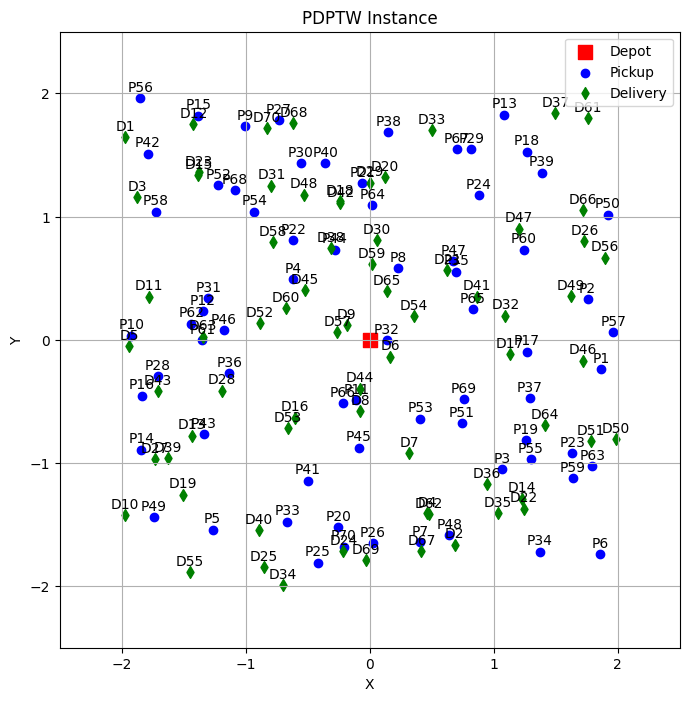

In [124]:
import random
from copy import deepcopy
import numpy as np
from copy import deepcopy
from instance import PDPTWInstance
from solution import PDPTWSolution
from solver import greedy_insertion_init
import matplotlib.pyplot as plt

n = 70
map_size = 2  
speed = 4 
extra_time = 10 
num_vehicles = 11
vehicle_capacity = 6 
battery_capacity = 255  
battery_consume_rate = 1
penalty = 5
gamma = 100

instance = PDPTWInstance(n, map_size, speed, extra_time, gamma, seed=1234)
instance.plot_instance()

Initial solution objective value 374.8112010792255
Unvisited pairs []
Unvisited pairs set()


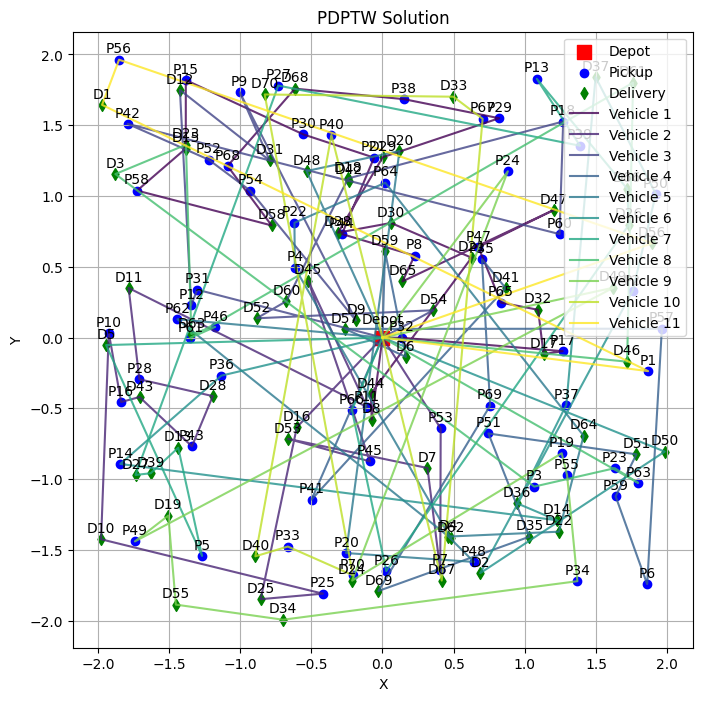

In [125]:
initial_solution = greedy_insertion_init(instance, num_vehicles, vehicle_capacity, battery_capacity, battery_consume_rate, penalty)
print("Initial solution objective value", initial_solution.objective_function())
print("Unvisited pairs", initial_solution.unvisited_pairs)
print("Unvisited pairs", initial_solution.unvisited_requests)
initial_solution.plot_solution()

In [126]:
df = instance.to_dataframe()

# Reference matrix for SISR removal
df_orders = df.iloc[1:, :]
stops = df_orders[['X', 'Y']].values
e_times = df_orders[['ReadyTime']].values
l_times = df_orders[['DueDate']].values

def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

d_matrix = []
for i in range(n):
    d_list = []
    for j in range(n):
        d_1 = euclidean_distance(stops[i], stops[j])  # pickup-pickup
        t_1 = abs(e_times[i] - e_times[j]) / 60 * speed
        dt_1 = d_1 + t_1 * 0.1

        d_2 = euclidean_distance(stops[i], stops[j + n])  # pickup-dropoff
        t_2 = abs(e_times[i] - l_times[j + n]) / 60 * speed
        dt_2 = d_2 + t_2 * 0.1

        d_3 = euclidean_distance(stops[i + n], stops[j])  # dropoff-pickup
        t_3 = abs(e_times[j] - l_times[i + n]) / 60 * speed
        dt_3 = d_3 + t_3 * 0.1

        d_4 = euclidean_distance(stops[i + n], stops[j + n])  # dropoff-dropoff
        t_4 = abs(e_times[j + n] - l_times[i + n]) / 60 * speed
        dt_4 = d_4 + t_4 * 0.1

        d_min = min(dt_1, dt_2, dt_3, dt_4)[0]
        d_list.append(d_min)
    d_matrix.append(d_list)

In [128]:
len(instance.calculate_distance_matrix())

142

In [127]:
# 设置ALNS参数
params_operators = {
    'num_removal': 5,
    'p': 3,
    'k': 3,
    'L_max': 10,
    'avg_remove_order': 10
}
max_no_improve = 25
segment_length = 25
num_segments = 50
r = 0.2 # update the weights
sigma = [10, 5, 1]
start_temp = 100
cooling_rate = 0.99
dist_matrix = instance.calculate_distance_matrix()
battery = 10

# 创建ALNS实例
alns = ALNS(
    initial_solution=initial_solution,
    params_operators=params_operators,
    d_matrix=d_matrix,
    dist_matrix = dist_matrix,
    battery = battery,
    max_no_improve=max_no_improve,
    segment_length=segment_length,
    num_segments=num_segments,
    r=r,
    sigma=sigma,
    start_temp=start_temp,
    cooling_rate=cooling_rate
)
# uncharged_solution, charged_solution = alns.run(1)

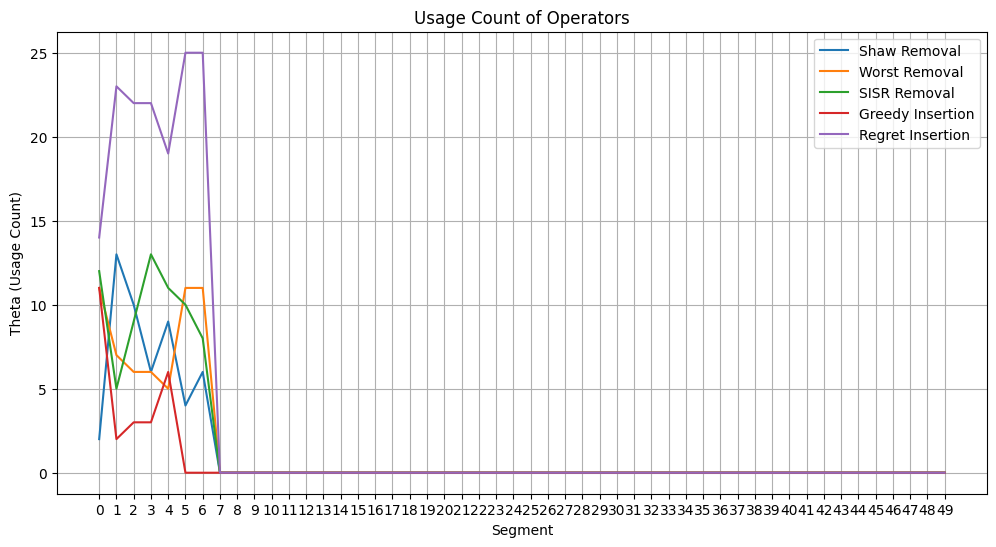

In [75]:
alns.plot_theta()

In [25]:
pip install --upgrade joblib

   ---------------------------------------- 0.0/301.8 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/301.8 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 301.8/301.8 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.3.2
    Uninstalling joblib-1.3.2:
      Successfully uninstalled joblib-1.3.2
Note: you may need to restart the kernel to use updated packages.


In [129]:
from joblib import Parallel, delayed
import time
start_time = time.time()
# Execute the function in parallel
p = 8
start_s = 1
uncharge_result_list = []
charge_result_list = []

results = Parallel(n_jobs=p, return_as="generator_unordered")(delayed(alns.run)(i) for i in range(start_s, start_s + p))
for i in range(p):
    a = next(results)
    uncharge_result_list.append(a[0])
    obj_1 = a[0].objective_function()
    charge_result_list.append(a[1])
    obj_2 = a[1].objective_function()
    print(obj_1, obj_2)
    print("--- %s seconds ---" % (time.time() - start_time))

294.2753840018387 325.21901934511095
--- 1958.0678341388702 seconds ---
289.33518014097405 314.139927327734
--- 2664.9734637737274 seconds ---
278.13206080755367 306.0439580913296
--- 2994.447516441345 seconds ---
271.20414081823844 305.13826589352664
--- 3040.996949672699 seconds ---
280.5088755286116 305.2650248907215
--- 3285.389703989029 seconds ---
272.1106979106058 283.1647438647436
--- 3730.9406378269196 seconds ---
269.8815216635674 287.0572576240528
--- 4457.879704475403 seconds ---
274.5609137854634 299.97069957983774
--- 5421.641376495361 seconds ---


In [ ]:
print("Uncharged_solution's objective value:", charge_result_list[6].objective_function())
print("Unvisited pairs", charge_result_list[6].unvisited_pairs)
charge_result_list[6].plot_solution()

## greedy charging station insertion

Charged_solution's objective value: 99.5594764521628
Unvisited pairs []


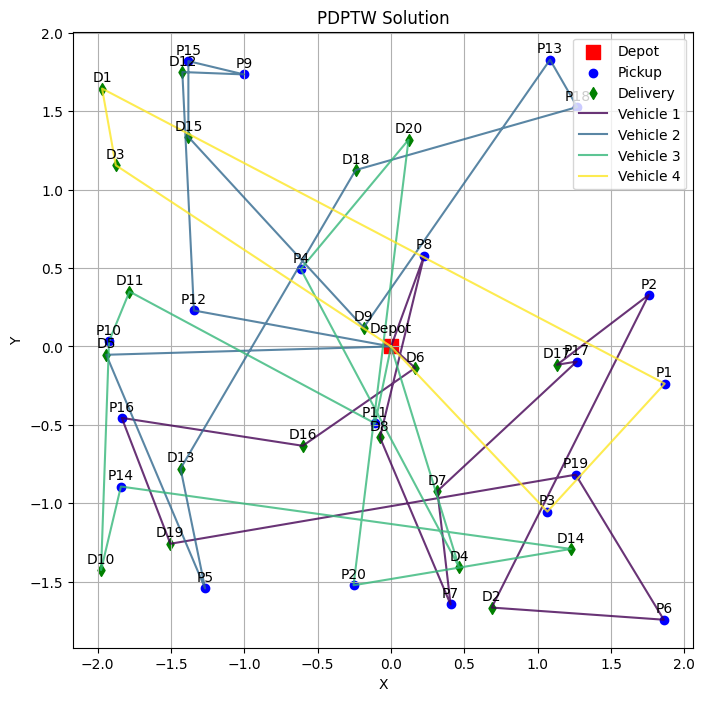

In [97]:
charging_insertion = ChargingStationInsertion(uncharged_solution)
charged_solution = charging_insertion.greedy_insertion()
print("Charged_solution's objective value:", charged_solution.objective_function())
print("Unvisited pairs", charged_solution.unvisited_pairs)
charged_solution.plot_solution()

In [52]:
print(uncharged_solution.routes)
print(uncharged_solution.total_delay_orders)
print(charged_solution.routes)
print(charged_solution.total_delay_orders)

[[0, 18, 14, 38, 9, 34, 13, 6, 29, 33, 26, 0], [0, 15, 10, 30, 16, 8, 35, 36, 28, 0], [0, 2, 11, 22, 5, 7, 1, 3, 31, 27, 25, 21, 23, 0], [0, 4, 12, 17, 24, 20, 37, 32, 40, 0]]
[3. 3. 6. 1.]
[[0, 18, 14, 38, 9, 34, 13, 6, 29, 19, 0, 39, 33, 26, 0], [0, 15, 10, 30, 16, 8, 35, 36, 28, 0], [0, 2, 11, 22, 5, 7, 1, 3, 31, 27, 25, 21, 23, 0], [0, 4, 12, 17, 24, 20, 37, 32, 40, 0]]
[4. 3. 6. 1.]


## similarity charging station insertion

In [40]:
uncharged_solution.route_arrival_times

array([array([  0.        ,  13.33557773,  54.7821836 ,  80.58917584,
               98.30990187, 110.02908879, 122.56367234, 156.02908755,
              189.62632072, 210.03189721, 228.91641543, 248.70206669]),
       array([  0.        ,  27.3450256 ,  53.51457938, 111.73654742,
              131.28791828, 142.40918579, 156.59625608, 177.01778546,
              199.39785501, 217.10125353])                           ,
       array([  0.        ,  23.01188309, 136.15196873, 154.73731966,
              172.2177564 , 181.97541689, 213.22527942, 235.83340487,
              254.45940583, 272.95912139, 295.40201866, 310.21013686]),
       array([  0.        ,  22.53797041, 148.27968689, 163.92564597,
              171.0832014 , 181.91389812, 195.43974835, 211.85116349,
              234.27687098, 263.79456962, 276.58356942, 288.7006361 ])],
      dtype=object)

Charged_solution's objective value: 118.13388389903045
Unvisited pairs []


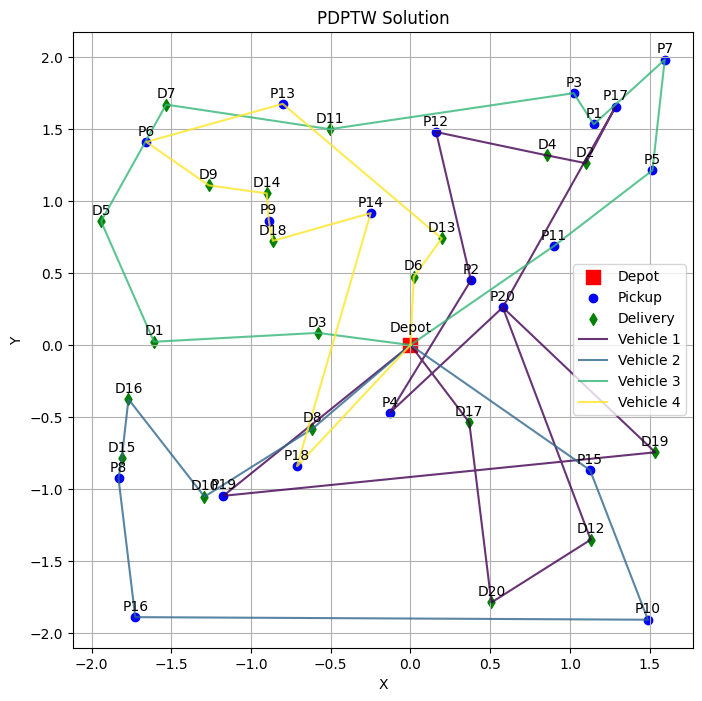

In [41]:
charging_insertion = ChargingStationInsertion(uncharged_solution)
charged_solution = charging_insertion.similarity_insertion()
print("Charged_solution's objective value:", charged_solution.objective_function())
print("Unvisited pairs", charged_solution.unvisited_pairs)
charged_solution.plot_solution()

In [42]:
routes = [[0,11,5,31,10,25,16,14,30,36,0,34,0],[0,24,7,27,6,17,37,26,0],[0,2,1,19,3,22,39,0,12,23,21,32,15,9,35,29],[0,8,20,28,0,40,18,13,38,33,0]]
solution = PDPTWSolution(instance, vehicle_capacity, battery_capacity, battery_consume_rate, routes, penalty)
solution.objective_function()

156.91737858709803

# Test framework